In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import LogNorm

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.vocab as vocab

warnings.filterwarnings("ignore")

#**Load vocabulary**

In [3]:
fasttext = vocab.FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [02:53, 38.0MB/s]                            
100%|██████████| 2519370/2519370 [06:10<00:00, 6802.76it/s]


#**Input**

In [48]:
# Data
#sentence = "MANY YEARS LATER as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice."
sentence = "my name is eder"
words = sentence.split()

input_dim = 300
sequence_length = len(words)
d_model = 300
batch_size = 1

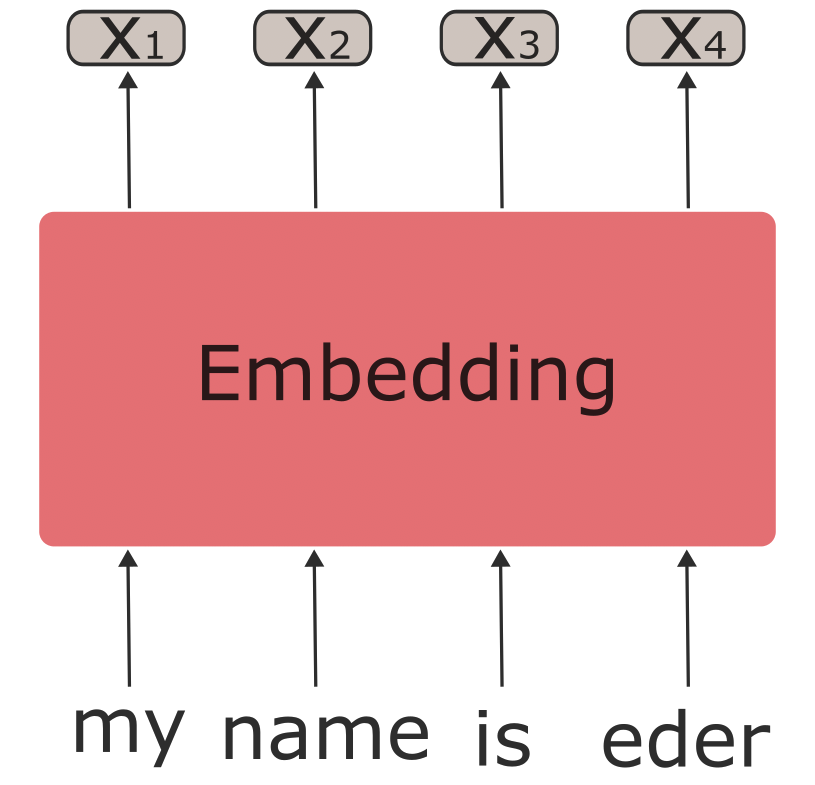

In [49]:
word_vectors = np.zeros((sequence_length, input_dim)) 
X = torch.empty(1, sequence_length, input_dim)

for word, i in zip(words, range(sequence_length)):

  word_vector = torch.tensor(fasttext[word])

  X[:,i,:] = word_vector.unsqueeze_(0)
  word_vectors[i,:] = word_vector.detach().cpu().numpy()

X.shape

torch.Size([1, 4, 300])

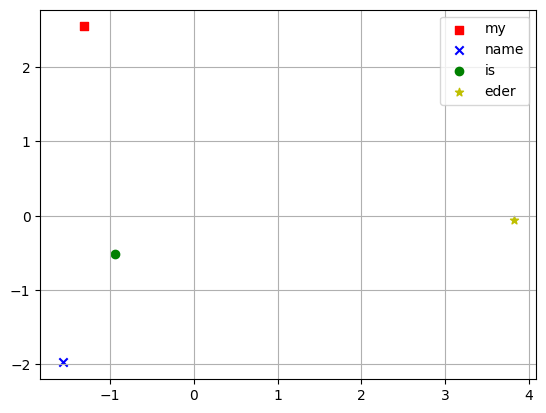

In [50]:
colors = ['r', 'b', 'g', 'y']
markers = ['s', 'x', 'o', '*']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(word_vectors)

for l, c, m in zip(range(len(X_pca)), colors, markers):
  plt.scatter(X_pca[l, 0], X_pca[l, 1], c=c, label=words[l], marker=m)
plt.legend()
plt.grid()
plt.show()

Remember:

$$ y = xA^{\top}+b$$

In [51]:
# The nn.Linear function apply a linear transform
qkv_layer = nn.Linear(input_dim , 3*d_model)
print('Network Structure : torch.nn.Linear({input},{output}) :\n'.format(input=input_dim, output=3*d_model), qkv_layer)


Network Structure : torch.nn.Linear(300,900) :
 Linear(in_features=300, out_features=900, bias=True)


In [52]:
qkv = qkv_layer(X)

qkv.shape

torch.Size([1, 4, 900])

In [53]:
num_heads = 6
head_dim = d_model // num_heads

batch_size, sequence_length, num_heads, 3 * head_dim
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

qkv.shape

torch.Size([1, 4, 6, 150])

*   1: text
*   4: sequence number (words)
*   6: attention heads
*   150: attention head size 


In [54]:
# batch_size, num_heads, sequence_length, 3*head_dim
qkv = qkv.permute(0, 2, 1, 3) 

qkv.shape

torch.Size([1, 6, 4, 150])

Tensor query, keys, and values

In [55]:
Q, K, V = qkv.chunk(3, dim=-1)
Q.shape, K.shape, V.shape

(torch.Size([1, 6, 4, 50]),
 torch.Size([1, 6, 4, 50]),
 torch.Size([1, 6, 4, 50]))

#**Multi-Head Attention**

Remember:

\begin{align}
  \textbf{H} = softmax \left( \frac{\textbf{Q} \textbf{K}^\top }{\sqrt{d_k}} \right) \textbf{V} 
\end{align}

\begin{align}
  \textbf{H} = \textbf{A} \textbf{V} 
\end{align}


In [56]:
print("Dimension of K: ", K.shape)
print("Dimension of transpose to all the vector: ", K.T.shape)
print("Dimension of transpose of only K: ", K.transpose(-2, -1).shape)

Dimension of K:  torch.Size([1, 6, 4, 50])
Dimension of transpose to all the vector:  torch.Size([50, 4, 6, 1])
Dimension of transpose of only K:  torch.Size([1, 6, 50, 4])


In [57]:
d_k = Q.size()[-1]
dot_softmax = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

dot_softmax.shape

torch.Size([1, 6, 4, 4])

Mask

In [58]:
mask = torch.full(dot_softmax.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] 

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [59]:
(dot_softmax + mask)[0][0]

tensor([[-0.0005,    -inf,    -inf,    -inf],
        [-0.0214, -0.0055,    -inf,    -inf],
        [ 0.0081, -0.0236,  0.0050,    -inf],
        [ 0.0020,  0.0162, -0.0085, -0.0208]], grad_fn=<SelectBackward0>)

In [60]:
dot_softmax = dot_softmax + mask

In [61]:
A = F.softmax(dot_softmax, dim=-1)
A.shape

torch.Size([1, 6, 4, 4])

In [62]:
A[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4960, 0.5040, 0.0000, 0.0000],
        [0.3372, 0.3267, 0.3362, 0.0000],
        [0.2512, 0.2548, 0.2485, 0.2455]], grad_fn=<SelectBackward0>)

In [63]:
H = torch.matmul(A, V)
H.shape

torch.Size([1, 6, 4, 50])

In [64]:
A[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4960, 0.5040, 0.0000, 0.0000],
        [0.3372, 0.3267, 0.3362, 0.0000],
        [0.2512, 0.2548, 0.2485, 0.2455]], grad_fn=<SelectBackward0>)

In [65]:
def scaled_dot_product_attention(Q, K, V, mask=None):
  
  d_k = Q.shape[-1]
  dot_softmax = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(d_k)

  if mask is not None:
    dot_softmax = dot_softmax + mask

  A = F.softmax(dot_softmax, dim=-1)
  H = torch.matmul(A, V)
  
  return H, A

In [66]:
H, A = scaled_dot_product_attention(Q, K, V, mask=mask)

H.shape, A.shape

(torch.Size([1, 6, 4, 50]), torch.Size([1, 6, 4, 4]))

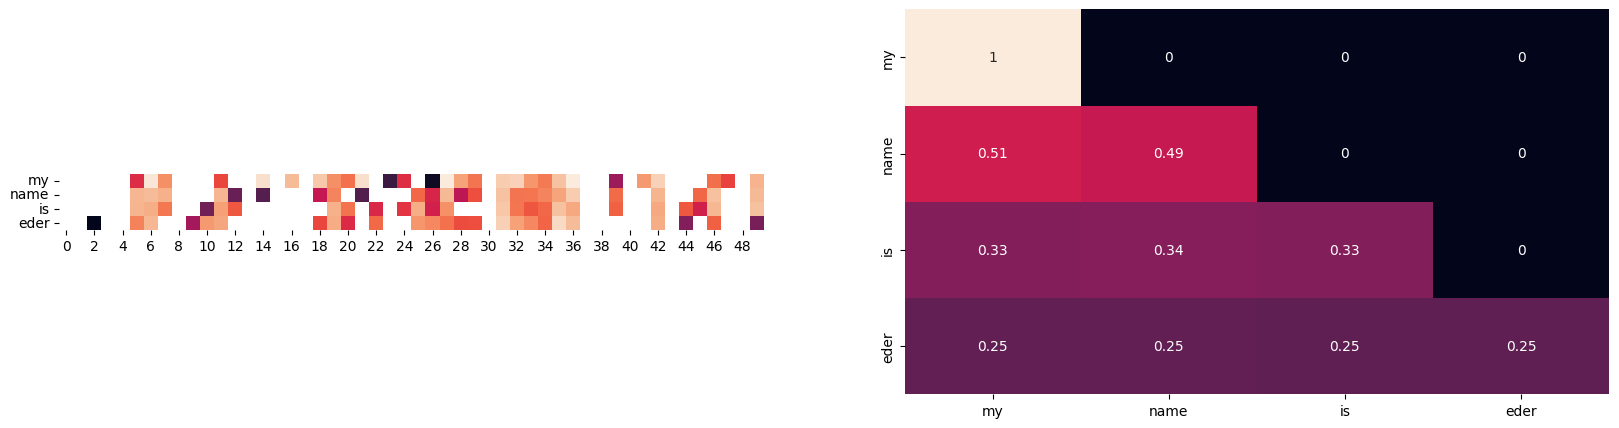

In [75]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(H[0][2].detach().cpu().numpy(), cbar=0, vmax=1, vmin=0, yticklabels=words, square=True, norm=LogNorm())
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(A[0][2].detach().cpu().numpy(), cbar=0, vmax=1, vmin=0, xticklabels=words, yticklabels=words, annot=True)
plt.show()